In [1]:
#pip install yfinance

!jupyter-nbconvert PRACTICA_2_AP_BMWYVOLS.ipynb --no-input --no-prompt --to html

## PRÁCTICA 2 BMW Y VOLKSWAGEN

En esta segunda práctica, analizaremos dos marcas de coches y sus precios de las acciones diarias. Durante el periodo que hemos escogido que es de 2009 hasta 2021. Son 7 ejercicios en los que se demuestra un desarrollo de dos modelos de autorregresivos siendo VAR y GARCH. 

Para comenzar lo dividimos en dos ambos dataset, en train y test para analizarlos posteriormente. Como vemos, la marca Volkswagen tiene un precio superior a BMW pero Volkswagen no es muy constante, ni podemos conocer su tendencia. Luego, analizaremos cada paso. 

También realizaremos las predicciones de ambas marcas y luego creare un sistema trading de BMW, para que el mercado sepa cuando debe comprar o vender, según los distintos objetivos. 

La información que tenemos es muy escasa, ya que solo con el precio no se puede predecir bien. Estaría mejor tener mas variables que fuesen capaces de demostrarnos alguna tendencia o ayudarnos a tomar decisiones.


Utilizando datos diarios de yahoo de los dos series (yfinance), debemos analizar la relación entre BMW (BMW.DE) y Volkswagen(VOW.DE), contestando a
las siguiente preguntas:
- Estima un modelo VAR mensual entre los dos activos. (Muestra:2009/01 a 2020/10) 
- ¿Cuál es la predicción para octubre de 2021 de los dos activos?. ¿Son buenas predicciones? 
- ¿Cuál de los dos activos es el lider y cual es el seguidor? 
- ¿Es la Volatilidad de BMW constante? Estimar el modelo garch de BMW (Muestra: Toda la disponible en Yahoo hasta el 31/10/2020) 
- ¿Cuál es la predicción para el mes de noviembre de 2020? ¿Son buenas predicciones? 
- Plantea un sistema de trading diario para BMW a partir del modelo Garch para el mes de noviembre de 2020. ¿Es rentable?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str
import seaborn as sns
from datetime import datetime
sns.set(rc={'figure.figsize':(12, 5)})

In [3]:
import yfinance as yf
import pandas as pd


In [4]:
bmw_o= yf.download(tickers = "BMW.DE", start="2009-01-01", end="2021-11-30",
        interval = "1d",
        group_by = 'ticker'
    )
vow= yf.download(tickers = "VOW.DE", start="2009-01-01", end="2021-10-31",
        interval = "1d",
        group_by = 'ticker'
    )

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
bmw=bmw_o["2009-01-01":"21-10-31"]

In [6]:
bmw=bmw[['Adj Close']].rename(columns={'Adj Close': 'Price_BMW'})
vow=vow[['Adj Close']].rename(columns={'Adj Close': 'Price_VOW'})

In [7]:
dataset=pd.merge(bmw,vow, on="Date")

In [8]:
dataset_m=dataset.resample("m").last()

In [9]:
dataset_m.isna().sum()

Price_BMW    0
Price_VOW    0
dtype: int64

In [10]:
print("El precio de octubre de 2021 es: ")
dataset_m.tail(1)

El precio de octubre de 2021 es: 


,Price_BMW,Price_VOW
Date,,
2021-10-31,81.088867,270.150177


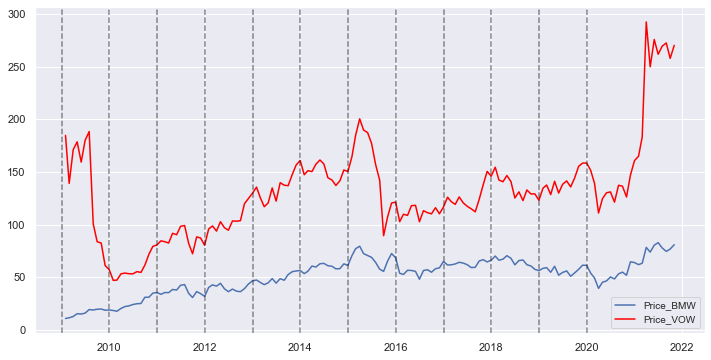

In [11]:
plt.figure(figsize=(12,6))
Price_BMW, = plt.plot(dataset_m['Price_BMW'])
Price_VOW, = plt.plot(dataset_m['Price_VOW'], color='red')

for year in range(2009, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.legend(['Price_BMW', 'Price_VOW'], fontsize=10)

## TRAIN Y TEST


In [12]:
train=dataset_m['2009-01-01':'2020-10-31']
test=dataset_m['2020-10-31':'2021-10-31']


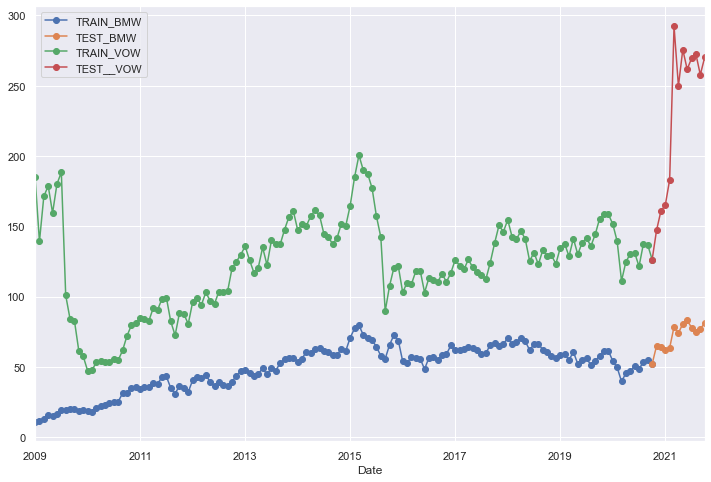

In [13]:
train['Price_BMW'].plot(legend=True,label='TRAIN_BMW',marker='o')
test['Price_BMW'].plot(legend=True,label='TEST_BMW',figsize=(12,8),marker='o');
train['Price_VOW'].plot(legend=True,label='TRAIN_VOW',marker='o')
test['Price_VOW'].plot(legend=True,label='TEST__VOW',figsize=(12,8),marker='o');

### Transformación estacionaria

In [14]:
d_data_train=train.diff().dropna()
d_data_train

,Price_BMW,Price_VOW
Date,,
2009-02-28,0.677483,-45.505127
2009-03-31,1.212347,32.064651
2009-04-30,2.650515,7.370132
2009-05-31,-0.322976,-19.222214
2009-06-30,0.869275,20.648590
...,...,...
2020-06-30,3.745232,0.823624
2020-07-31,-1.881493,-9.700455
2020-08-31,4.836857,16.014908


<AxesSubplot:xlabel='Date'>

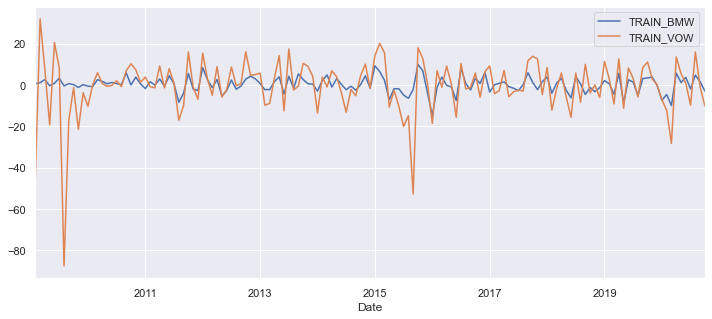

In [15]:
d_data_train['Price_BMW'].plot(legend=True,label='TRAIN_BMW')
d_data_train['Price_VOW'].plot(legend=True,label='TRAIN_VOW')

En la gráfica, tenemos las variables train, test y forecast de ambas marcas, tanto BMW como Volkswagen. La línea superior es la de VOL y la inferior la de BMW. La primera marca tiene los datos bastante mejor que BMW, pero tiene altibajos, no es constante a lo largo del tiempo, en cambio, BMW es más constante y presenta un ligero crecimiento, pero no tiene caídas grandes pero tampoco crecimiento. LA caida que tiene VOL es por una crisis de diesel.

“VW cars being sold in America had a "defeat device" - or software - in diesel engines that could detect when they were being tested, changing the performance accordingly to improve results. “ BBC news. La caída de vol fue provocada por la venta de los coches con estos dispositivos, ya que modificaban el resultado de rendimiento cuando se sometían a pruebas.  Esto provocó una caída en 2015/2016 llamada la crisis de dieselgate.


### Autocorrelación

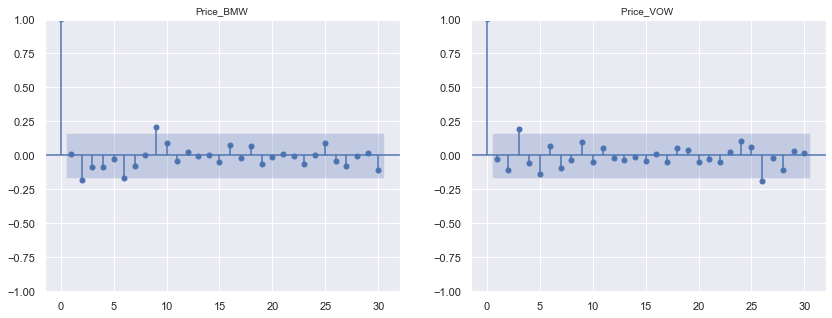

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.close()
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

plot_pacf(d_data_train['Price_BMW'].dropna(), lags=30,method='ywm', ax=ax1)
ax1.set_title('Price_BMW', fontsize=10)

plot_pacf(d_data_train['Price_VOW'].dropna(), lags=30, method='ywm', ax=ax2)
ax2.set_title('Price_VOW ', fontsize=10)

plt.show()
plt.close()

## TEST DE CAUSALIDAD DE GRANGER 

#### ¿Cuál de los dos activos es el líder y cuál es el seguidor?

Para ver que activo es líder y cual es seguidor, he calculado el test de causalidad de Granger. Este test comprueba si se cumple o no la hipótesis nula, en este caso, si una variable explica el comportamiento de otra. Tras estimar el modelo Var, luego se estudia los coeficientes reales que se estiman, y para estudiarlos se necesitan calcular los estadísticos de causalidad de Granger. 

Para que la variable explique el comportamiento de otra el p-valor tiene que ser menor que el 5%. En este caso, en ninguno de los dos test de granger que hacemos, hay valores inferiores a 5%. Por lo tanto, tendríamos que aceptar la hipótesis nula. En este test, hay que señalar que hace inferencias sobre el pronóstico y no sobre la causalidad verdadera. No hay evidencias que ninguno de nuestros activos explique el comportamiento del otro. Pero, si tuviese que decidirme por uno, BMW es el líder.


In [17]:
print('El test de causalidad de Granger de VOW a BMW es: ')

gc_res = grangercausalitytests(d_data_train[['Price_BMW','Price_VOW']], 3)

El test de causalidad de Granger de VOW a BMW es: 

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6458  , p=0.2017  , df_denom=137, df_num=1
ssr based chi2 test:   chi2=1.6818  , p=0.1947  , df=1
likelihood ratio test: chi2=1.6718  , p=0.1960  , df=1
parameter F test:         F=1.6458  , p=0.2017  , df_denom=137, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1497  , p=0.3198  , df_denom=134, df_num=2
ssr based chi2 test:   chi2=2.3852  , p=0.3034  , df=2
likelihood ratio test: chi2=2.3650  , p=0.3065  , df=2
parameter F test:         F=1.1497  , p=0.3198  , df_denom=134, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9560  , p=0.4157  , df_denom=131, df_num=3
ssr based chi2 test:   chi2=3.0212  , p=0.3884  , df=3
likelihood ratio test: chi2=2.9886  , p=0.3934  , df=3
parameter F test:         F=0.9560  , p=0.4157  , df_denom=131, df_num=3


In [18]:
print('El test de causalidad de Granger de BMW a VOW es: ')

gc_res = grangercausalitytests(d_data_train[['Price_VOW','Price_BMW']], 3)

El test de causalidad de Granger de BMW a VOW es: 

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1163  , p=0.2926  , df_denom=137, df_num=1
ssr based chi2 test:   chi2=1.1407  , p=0.2855  , df=1
likelihood ratio test: chi2=1.1361  , p=0.2865  , df=1
parameter F test:         F=1.1163  , p=0.2926  , df_denom=137, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3506  , p=0.7049  , df_denom=134, df_num=2
ssr based chi2 test:   chi2=0.7274  , p=0.6951  , df=2
likelihood ratio test: chi2=0.7255  , p=0.6958  , df=2
parameter F test:         F=0.3506  , p=0.7049  , df_denom=134, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8066  , p=0.1491  , df_denom=131, df_num=3
ssr based chi2 test:   chi2=5.7094  , p=0.1266  , df=3
likelihood ratio test: chi2=5.5944  , p=0.1331  , df=3
parameter F test:         F=1.8066  , p=0.1491  , df_denom=131, df_num=3


# MODELO VAR

#### Estima un modelo VAR mensual entre los dos activos. (Muestra:2009/01 a 2020/10) 

El modelo VAR (modelos autorregresivos vectoriales) se utiliza este modelo para series temporales como en nuestro caso, siendo multivariantes y observamos que existen dependencias dinámicas entre series. Este modelo es capaz de relacionar los datos del día de hoy con datos pasados. Este modelo se compone por un algoritmo para predecir que es utilizado para dos o más series de tiempo, siendo una relación bidireccional.

Para que podamos crear este tipo de modelo en nuestra práctica tenemos que seleccionar el número de lags (que son los retardos en nuestro modelo) Y para que el modelo sea optimo hay que elegir el modelo var con p* que minimiza AIC.
También es importante en nuestro modelo, que la serie que vamos a predecir sea estacionaria, es decir, constante en media y varianza. En esta parte de la práctica, quitamos la estacionariedad, para que no nos afecte a la hora de evaluar el modelo. Encontramos que ya no hay estacionariedad pero si que hay volatilidad. Más tarde la estudiaremos.


**1. Definir el modelo**

In [19]:
# definir el VAR
model = VAR(d_data_train)
# maximo lag a seleccionar
model.select_order(30)

**2. Estimar el modelo**

In [20]:
# estimar los modelos y seleccionar
results = model.fit(maxlags=30, ic='aic')

In [21]:
# lag con menor AIC
results.k_ar

2

**3 Resumen del modelo**

In [22]:
# El modelo estimado
print('Modelo estimado por VAR')
results.summary()

Modelo estimado por VAR


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 31, Oct, 2022
Time:                     14:17:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    7.69313
Nobs:                     139.000    HQIC:                   7.56781
Log likelihood:          -904.465    FPE:                    1775.93
AIC:                      7.48202    Det(Omega_mle):         1654.74
--------------------------------------------------------------------
Results for equation Price_BMW
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.287416         0.330788            0.869           0.385
L1.Price_BMW         0.069048         0.102597            0.673           0.501
L1.Price_VOW        -0.035054         0.030303           -1.

Esta es la respuesta al modelo var, es importante ver los datos y que variables y probabilidades afectan al modelo. En cuanto, a probabilidades, ni la ecuación de bmw ni vol, son menores que el 5%, por lo tanto, NO son significativas y rechazaríamos la hipótesis nula. El AIC mas bajo que se ha encontrado es 7,48 siendo el lag 3 meses.

In [23]:
for i in [1,2,3,4,5]:
    result = model.fit(i)
    try:
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        continue

Lag Order = 1
AIC :  7.535773445820645
BIC :  7.6618438353610445
FPE :  1873.9177447707593
HQIC:  7.587004681548211 

Lag Order = 2
AIC :  7.482018084529526
BIC :  7.693131317128856
FPE :  1775.9312135509963
HQIC:  7.567808885686413 

Lag Order = 3
AIC :  7.450729538206747
BIC :  7.747697303367622
FPE :  1721.4183049581109
HQIC:  7.571409897540845 

Lag Order = 4
AIC :  7.502513558089077
BIC :  7.8861606870299985
FPE :  1813.2798405295373
HQIC:  7.658418430576448 

Lag Order = 5
AIC :  7.515868420559966
BIC :  7.987033181487857
FPE :  1838.2635969822202
HQIC:  7.707337819430997 



#### Gráfico de los datos

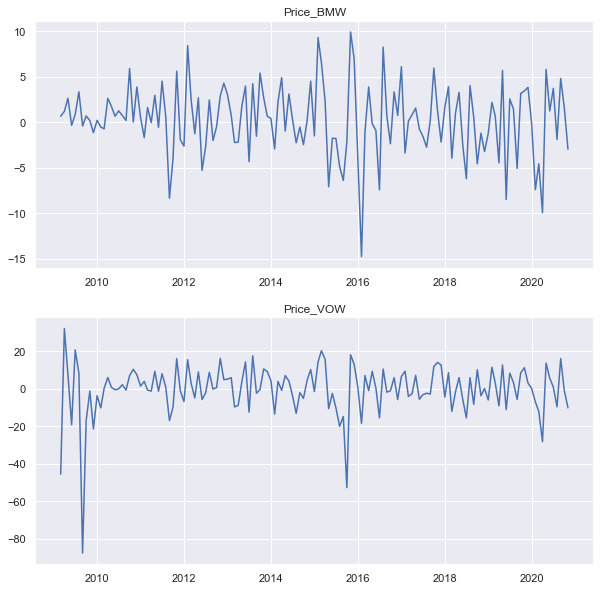

In [24]:
results.plot();

### Correlaciones de los residuos


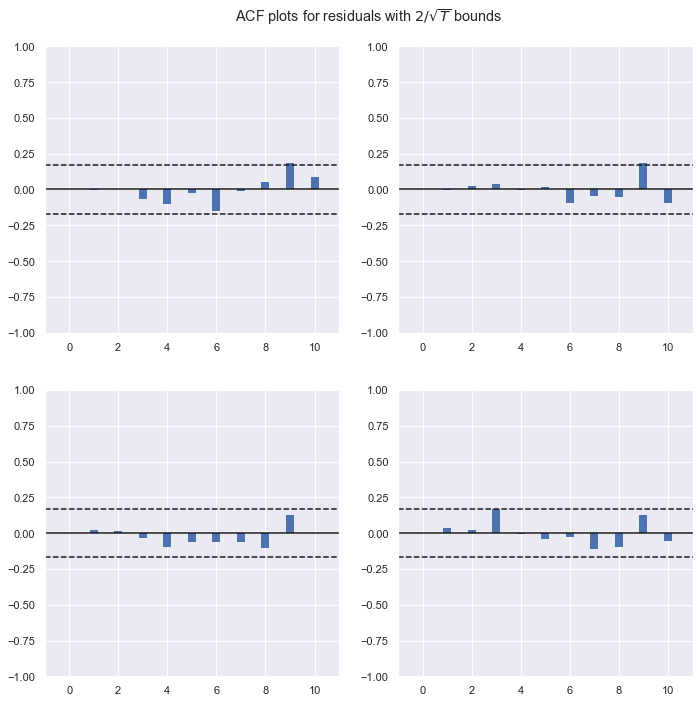

In [25]:
results.plot_acorr();

**4. Predecir el modelo**


In [26]:
lag_order = results.k_ar
lag_order

2

In [27]:
d_data_train.values[-lag_order:]

array([[  1.63299179,  -0.91516113],
       [ -2.93761444, -10.21199036]])

In [28]:
results.forecast(d_data_train.values[-lag_order:], 10)

array([[ 0.26600221, -0.42754678],
       [ 0.97649059,  0.27557897],
       [ 0.32436146, -0.21418794],
       [ 0.18828524, -0.2495485 ],
       [ 0.27501984, -0.35520984],
       [ 0.30260721, -0.36760366],
       [ 0.29719593, -0.32849825],
       [ 0.29238141, -0.3213932 ],
       [ 0.29135641, -0.32881861],
       [ 0.2919408 , -0.33105283]])

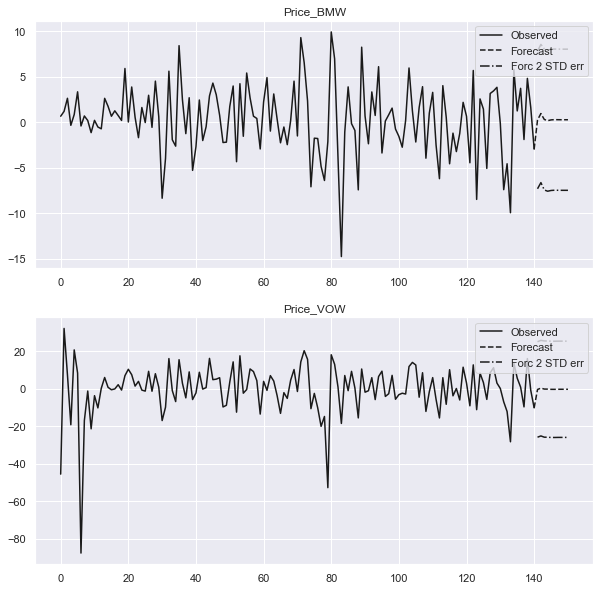

In [29]:
results.plot_forecast(10);

In [30]:
f_data=train.values[-1:]+results.forecast(d_data_train.values[-lag_order:], 13)
f_data

array([[ 52.34426072, 125.8988845 ],
       [ 53.0547491 , 126.60201024],
       [ 52.40261998, 126.11224334],
       [ 52.26654375, 126.07688277],
       [ 52.35327836, 125.97122143],
       [ 52.38086573, 125.95882761],
       [ 52.37545445, 125.99793302],
       [ 52.37063993, 126.00503807],
       [ 52.36961492, 125.99761267],
       [ 52.37019931, 125.99537844],
       [ 52.3706569 , 125.99626227],
       [ 52.3706487 , 125.99677566],
       [ 52.37054815, 125.99675736]])

In [31]:
data_fore=pd.DataFrame(f_data)
data_fore.index=test.index
data_fore.rename(columns={0: 'BMW', 1: 'VOW'}, inplace=True)
data_fore

,BMW,VOW
Date,,
2020-10-31,52.344261,125.898884
2020-11-30,53.054749,126.602010
2020-12-31,52.402620,126.112243
2021-01-31,52.266544,126.076883
2021-02-28,52.353278,125.971221
2021-03-31,52.380866,125.958828
2021-04-30,52.375454,125.997933
2021-05-31,52.370640,126.005038
2021-06-30,52.369615,125.997613


Por último, si observamos la predicción con nuestro modelo VAR, en ambas compañías, no nos muestra información. Por lo tanto, el modelo VAR no sirve mucho en nuestra práctica porque no predice. Analizaremos otro modelo, para ver si obtenemos otros resultados. 

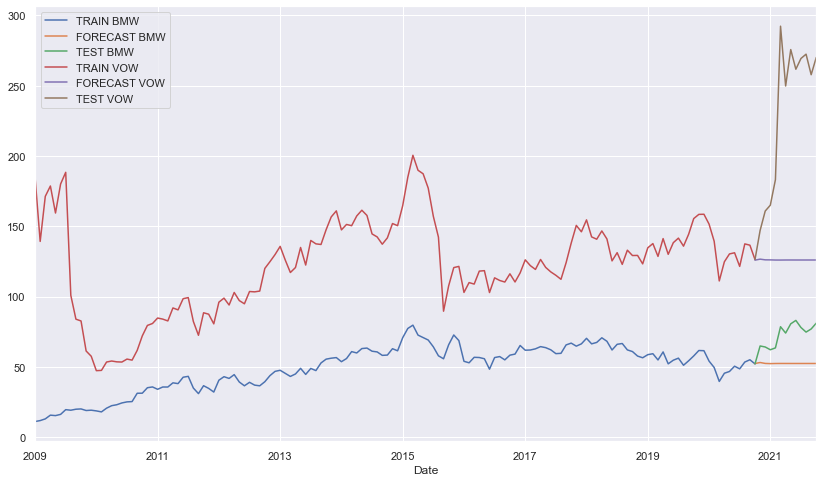

In [32]:
train['Price_BMW'].plot(legend=True,label='TRAIN BMW',)
data_fore['BMW'].plot(legend=True,label='FORECAST BMW')
test['Price_BMW'].plot(legend=True,label='TEST BMW',figsize=(14,8));
train['Price_VOW'].plot(legend=True,label='TRAIN VOW',)
data_fore['VOW'].plot(legend=True,label='FORECAST VOW')
test['Price_VOW'].plot(legend=True,label='TEST VOW',figsize=(14,8));

**5. Evaluar el modelo**

In [33]:
from statsmodels.tools.eval_measures import rmse

RMSE_BMW = rmse(data_fore['BMW'],test['Price_BMW'])
print(f'El RMSE de BMW es: {RMSE_BMW}')
RMSE_VOW = rmse(data_fore['VOW'],test['Price_VOW'])
print(f'El RMSE de VOW es: {RMSE_VOW}')

# MIRAR ESTO

El RMSE de BMW es: 21.419341002611645
El RMSE de VOW es: 114.50311049739763


Ambas ecuaciones podemos estimarlas y ver cual de ellas tiene un menor RMSE (error cuadrático medio) BMW en este caso, tiene un mejor RMSE, es decir, un RMSE más bajo. Siendo 5,5 veces inferior a VOW, con un 114.

#### ¿Cuál es la predicción para octubre de 2021 de los dos activos? ¿Son buenas predicciones? 

In [34]:
print(f'La predicción de Octubre es de 2021 es:')
data_fore.tail(1)

La predicción de Octubre es de 2021 es:


,BMW,VOW
Date,,
2021-10-31,52.370548,125.996757


Los dos activos tienen unas predicciones en octubre de 52 en BMW y 126 en VOL.  El modelo VAR, en este caso, no ha sido un buen modelo. Comparando con el resultado “real”, BMW es 30 puntos menos y en VOW es 145 puntos menos. Por lo tanto, nuestra predicción es errónea. La predicción es muy importante, ya que es lo estimamos que sean nuestras ventas en el futuro, si predecimos menos de lo que realmente se va a vender, pueden ocasionarse problemas como el out of stock.

La Función de var que es conocida como de las más importantes, es para hacer predicciones. Nosotros, tras haber tomado la decisión de hacer este modelo, nos encontramos que es un modelo malo. Puede ser tanto errores de los datos, como de falta de información o de mala ejecución del modelo.



#### Descomposición del error de predicción

In [35]:
fevd = results.fevd(5)

In [36]:
fevd.summary()

FEVD for Price_BMW
     Price_BMW  Price_VOW
0     1.000000   0.000000
1     0.990910   0.009090
2     0.984518   0.015482
3     0.984146   0.015854
4     0.983610   0.016390

FEVD for Price_VOW
     Price_BMW  Price_VOW
0     0.339078   0.660922
1     0.340476   0.659524
2     0.336023   0.663977
3     0.336141   0.663859
4     0.336193   0.663807




## 2. MODELO

En este paso, realizamos otro modelo, que es el modelo GARCH. En este caso, solo lo realizaremos para BMW. Este modelo, es también un autorregresivo que recoge todas las agrupaciones de volatilidad de las rentabilidades de nuestros datos mediante la varianza condicional de estas. Es un modelo que es generalizado por que tiene en cuenta tanto pasado como presente y la varianza del futuro depende de la varianza del pasado. En este paso, vamos a predecir la volatilidad de BMW. 

Para el modelo GARCH necesitamos saber los componentes p y q. Vamos a utilizar p=1 y q=1, este modelo depende de 1 varianza pasada (p) y un error pasado (q) Y la realizaremos bajo la T-student, analizamos el modelo bajo T-student, porque este la distribución normal tiene colas anchas y puede obtener los puntos mas extremos, en cambio, la T-student es más alta y con menos colas. 

La volatilidad es muy importante conocerla, es una medida que calcula cuanto oscilan sus rendimientos alrededor de la media. Conseguimos analizar como fluctúa a lo largo del periodo de tiempo y conseguir predecir los valores que son posibles de obtener en el futuro. Es decir, como afectan las volatilidades del pasado para predecir el futuro.


In [37]:
bmw_garch=bmw_o['2009-01-31':'2020-10-31']

In [38]:
bmw_garch

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-02-02,18.309999,18.480000,17.395000,17.610001,10.465375,4149233
2009-02-03,17.650000,18.155001,17.340000,18.125000,10.771431,3953543
2009-02-04,18.200001,19.790001,17.834999,19.370001,11.511320,4844579
2009-02-05,18.840000,19.605000,18.320000,19.594999,11.645033,4184677
2009-02-06,19.900000,21.930000,19.895000,21.865000,12.994060,7709504
...,...,...,...,...,...,...
2020-10-26,62.860001,64.120003,62.779999,63.209999,56.098618,1118941
2020-10-27,63.230000,63.290001,61.340000,61.470001,54.554375,1839591
2020-10-28,59.730000,59.959999,57.250000,58.060001,51.528015,3729376


In [44]:
bmw_garch=bmw_garch[['Adj Close']].rename(columns={'Adj Close': 'Price_BMW'})
bmw_garch

,Price_BMW
Date,
2009-02-02,10.465375
2009-02-03,10.771431
2009-02-04,11.511320
2009-02-05,11.645033
2009-02-06,12.994060
...,...
2020-10-26,56.098618
2020-10-27,54.554375
2020-10-28,51.528015


bmw_garch=bmw_garch_1.copy()
bmw_garch

### Transformación estacionaria

In [45]:
bmw_garch['log_ret_bmw'] =np.log(bmw_garch.Price_BMW).diff()
bmw_garch.tail()


,Price_BMW,log_ret_bmw
Date,,
2020-10-26,56.098618,-0.011326
2020-10-27,54.554375,-0.027913
2020-10-28,51.528015,-0.057072
2020-10-29,51.767639,0.004640
2020-10-30,52.078259,0.005982


### Volatilidad

In [46]:
bmw_garch['Squared_bmw'] =bmw_garch['log_ret_bmw']**2
bmw_garch.tail()

,Price_BMW,log_ret_bmw,Squared_bmw
Date,,,
2020-10-26,56.098618,-0.011326,0.000128
2020-10-27,54.554375,-0.027913,0.000779
2020-10-28,51.528015,-0.057072,0.003257
2020-10-29,51.767639,0.004640,0.000022
2020-10-30,52.078259,0.005982,0.000036


Text(0.5, 0.8, 'Volatilidad')

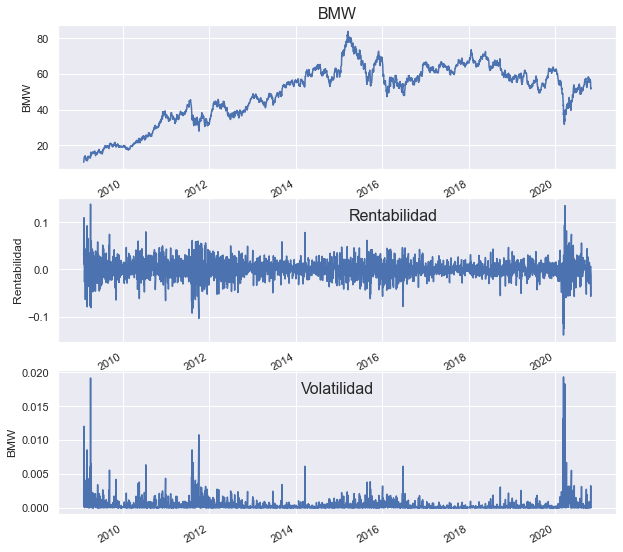

In [48]:
fig = plt.figure(figsize=(10,10))
plt.subplot(311) #3filas y 1 col y el 1 elemto
ax=bmw_garch.Price_BMW.plot( linestyle='-')
ax.set_ylabel('BMW')
ax.set_xlabel('')
ax.set_title('BMW', y=1, fontsize = 16)
plt.subplot(312) #3filas y 1 col y el 2elemto
ax=bmw_garch.log_ret_bmw.plot( linestyle='-')
ax.set_ylabel('Rentabilidad')
ax.set_xlabel('')
ax.set_title('Rentabilidad', y=0.8, x=0.6,fontsize = 16)
plt.subplot(313) #3filas y 1 col y el 3elemto
ax=bmw_garch.Squared_bmw.plot( linestyle='-')
ax.set_ylabel('BMW')
ax.set_xlabel('')
ax.set_title('Volatilidad', y=0.8, fontsize = 16)
#serie temporal, rentimiento y la volatilidad

El grafico que está arriba, tenemos la serie temporal (1), la rentabilidad de la serie (2) y nos muestra cual es la volatilidad de nuestros datos de BMW. 
Pero encontramos que los datos no son volátiles. Por lo que tenemos que estudiar este modelo, para hacer que los datos se han volátiles y así poder estudiar GARCH.


In [49]:
# Autocorrelation Fuction Original Time Series
from sktime.utils.plotting import plot_correlations

In [50]:
bmw_garch_vol=bmw_garch['Squared_bmw'].astype('float64').to_period('D').sort_index().dropna()
bmw_garch_vol.tail()

Date
2020-10-26    0.000128
2020-10-27    0.000779
2020-10-28    0.003257
2020-10-29    0.000022
2020-10-30    0.000036
Freq: D, Name: Squared_bmw, dtype: float64

In [51]:
bmw_garch_vol

Date
2009-02-03    0.000831
2009-02-04    0.004413
2009-02-05    0.000133
2009-02-06    0.012015
2009-02-09    0.002180
                ...   
2020-10-26    0.000128
2020-10-27    0.000779
2020-10-28    0.003257
2020-10-29    0.000022
2020-10-30    0.000036
Freq: D, Name: Squared_bmw, Length: 2981, dtype: float64

### a. Autocorrelacion

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='Squared_bmw'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

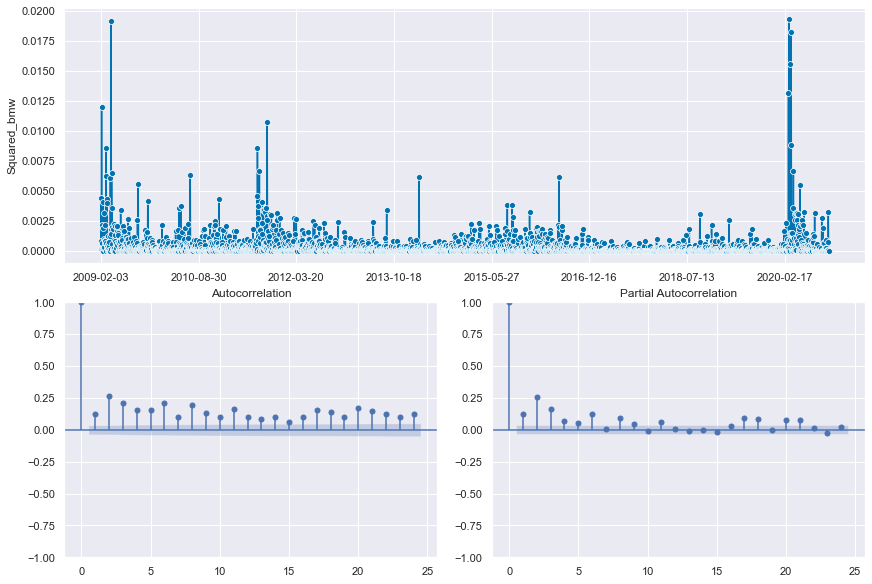

In [52]:
plot_correlations(bmw_garch_vol)

In [54]:
import statsmodels.api as sm
test_Ljung_Box=sm.stats.acorr_ljungbox

### b. Ljung-Box

In [55]:
test_Ljung_Box(bmw_garch_vol, lags=[1,2,3], return_df=True)

,lb_stat,lb_pvalue
1,44.973982,1.996698e-11
2,252.968795,1.170912e-55
3,381.231274,2.572466e-82


In [56]:
#pip install arch

## MODELO GARCH

Para crear el modelo GARCH había que seguir los siguientes pasos: 
El primer paso es importante estimar el modelo con modelo ARIMA, por que necesitamos la ecuación de la media. El modelo GARCH (1,1) “es una ARMA(1,1) sobre la varianza de los errores” Por lo tanto, este es el paso 1 para especificar el modelo. 

El segundo paso, es realizar el cálculo del logaritmo de la diferencia entre días y elevarla al cuadrado, que se utiliza para calcular la volatilidad. Mas tarde, especificamos el modelo y estimamos. 

También es importante verificar la volatilidad del modelo, en esta práctica la realizaré por dos modelos, el ACF/PACF y el test de Ljung Box.  Queremos verificar estadísticamente si los datos valen 0 y así, verificar si son o no ruido blanco y comprobamos si la varianza es o no constante.


In [57]:
from arch.univariate import ARX
from arch.univariate import ARCH, GARCH

In [58]:
ar_bmw = ARX(100*bmw_garch['log_ret_bmw'].dropna(), lags=[1])
print(ar_bmw.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:            log_ret_bmw   R-squared:                       0.002
Mean Model:                        AR   Adj. R-squared:                  0.002
Vol Model:          Constant Variance   Log-Likelihood:               -6211.54
Distribution:                  Normal   AIC:                           12429.1
Method:            Maximum Likelihood   BIC:                           12447.1
                                        No. Observations:                 2980
Date:                Mon, Oct 31 2022   Df Residuals:                     2978
Time:                        14:20:26   Df Model:                            2
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------------------------
Const             0.0504  3.571e-02      1.412

### a. MODELO GARCH 1,1

In [59]:
# MODELO 
# GARCH(1,1)
ar_bmw.volatility = GARCH(p=1,q=1)
res = ar_bmw.fit(update_freq=0, disp="off")
print(res.summary())
#ccorr y los coef q son mayor q0  mayor q cero son significativo 

                           AR - GARCH Model Results                           
Dep. Variable:            log_ret_bmw   R-squared:                       0.002
Mean Model:                        AR   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -5826.31
Distribution:                  Normal   AIC:                           11662.6
Method:            Maximum Likelihood   BIC:                           11692.6
                                        No. Observations:                 2980
Date:                Mon, Oct 31 2022   Df Residuals:                     2978
Time:                        14:20:27   Df Model:                            2
                                  Mean Model                                 
                    coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------------------------------------
Const             0.0593  2.975e-02      1.995  4.610e-

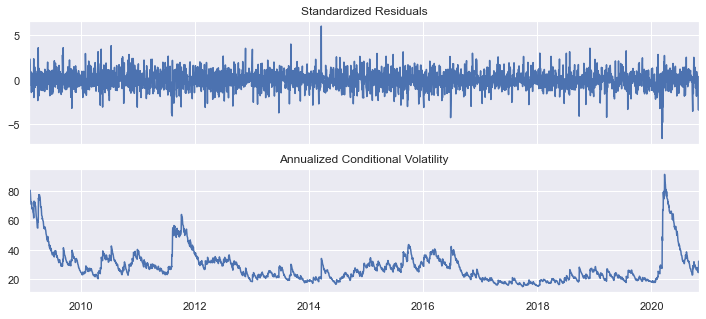

In [60]:
fig = res.plot(annualize="D")

### a. Análisis de Residuos

In [61]:
# Análisis Residuos
mod1_std_resid=(res.resid / res.conditional_volatility).astype('float64').to_period('d').sort_index().dropna()
mod1_std_resid 
#es z

Date
2009-02-04    1.384154
2009-02-05    0.143645
2009-02-06    2.367287
2009-02-09    0.773542
2009-02-10   -0.602375
                ...   
2020-10-26   -0.754228
2020-10-27   -1.787140
2020-10-28   -3.403947
2020-10-29    0.374679
2020-10-30    0.255848
Freq: D, Length: 2980, dtype: float64

### b. Autocorrelacion

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

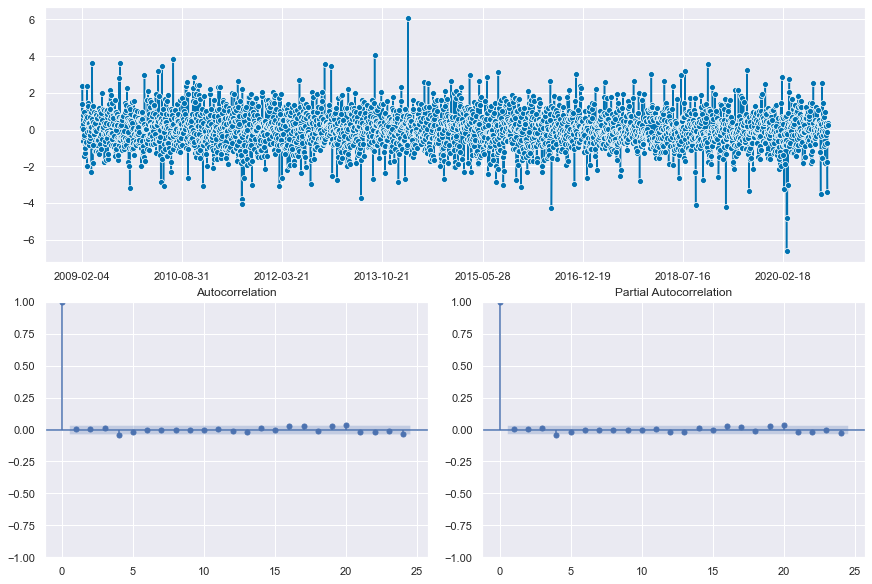

In [62]:
# Plot Autocorrelation
plot_correlations(mod1_std_resid)
#vemos q la media esta entre la cinta-- la media esta calculada bien

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

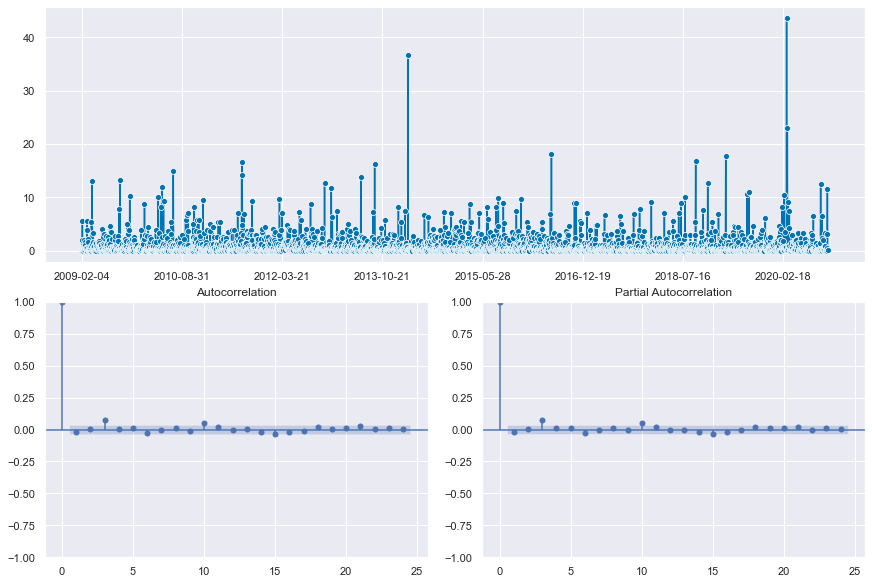

In [63]:
# Plot Autocorrelation
plot_correlations(mod1_std_resid**2)
# varianza esta bien calculada pq estan los putnos dentro de la cinta

### c. Ljung-Box

In [64]:
test_Ljung_Box(mod1_std_resid**2, lags=[1,2,3], return_df=True)

,lb_stat,lb_pvalue
1,1.066607,0.301713
2,1.108915,0.574384
3,17.603739,0.000531


### MODELO GARCH 1,1 + T-student

#### ¿Es la Volatilidad de BMW constante? Estimar el modelo GARCH de BMW (Muestra: Toda la disponible en Yahoo hasta el 31/10/2020

In [65]:
from arch.univariate import StudentsT

In [66]:
ar_bmw.distribution = StudentsT()
res = ar_bmw.fit(update_freq=0, disp="off")
print(res.summary())

                              AR - GARCH Model Results                              
Dep. Variable:                  log_ret_bmw   R-squared:                       0.002
Mean Model:                              AR   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:               -5739.52
Distribution:      Standardized Student's t   AIC:                           11491.0
Method:                  Maximum Likelihood   BIC:                           11527.0
                                              No. Observations:                 2980
Date:                      Mon, Oct 31 2022   Df Residuals:                     2978
Time:                              14:20:30   Df Model:                            2
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------

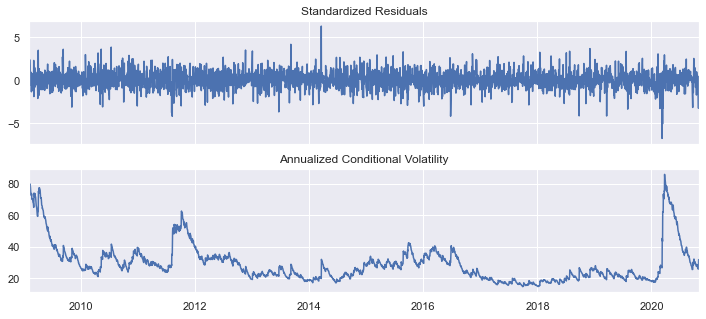

In [67]:
fig = res.plot(annualize="D")

#### a. Análisis de residuos

In [68]:
# Análisis Residuos
mod1_std_resid=(res.resid / res.conditional_volatility).astype('float64').to_period('D').sort_index().dropna()
mod1_std_resid

Date
2009-02-04    1.385241
2009-02-05    0.144093
2009-02-06    2.356302
2009-02-09    0.777725
2009-02-10   -0.603469
                ...   
2020-10-26   -0.705026
2020-10-27   -1.694661
2020-10-28   -3.297436
2020-10-29    0.409692
2020-10-30    0.274075
Freq: D, Length: 2980, dtype: float64

#### b. Autocorrelación

Este gráfico es el ACF y PACF, y analiza las autocorrelaciones y las correlaciones parciales de BMW. Nos encontramos que el 3 día es significativo. Correlación parcial nos muestra si cada mes es directamente significativo por ejemplo, BMW , es capaz de explicar lo que pasa a día de hoy con los 3 meses anteriores porque el 3 mes es significativo. También encontramos que la media y la varianza están bien calculadas porque, en este caso, todos los puntos están dentro de la banda azul, y eso nos muestra que están bien calculadas. Esta imagen, solo nos muestra la varianza, pero también he calculado el de la media. Lo que esta dentro de la banda azul se llama ruido blanco.

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

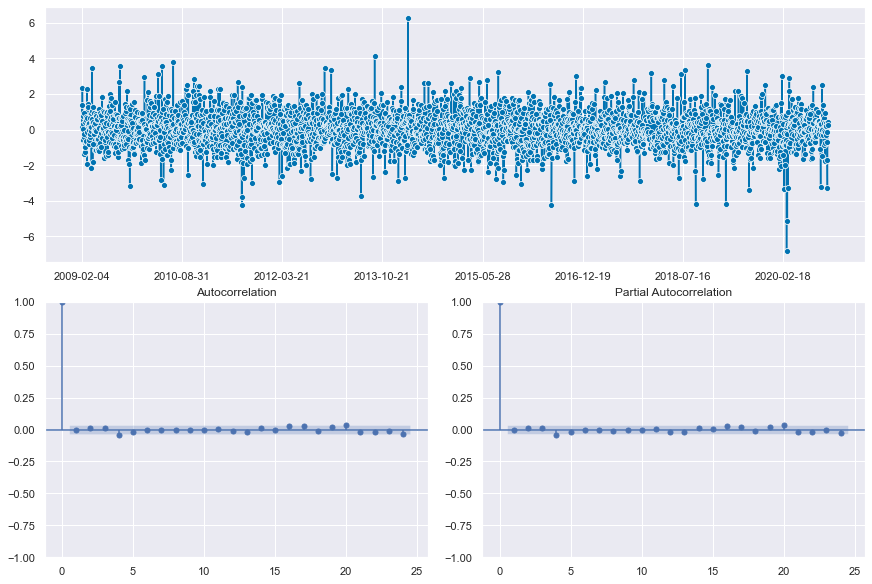

In [69]:
# Plot Autocorrelation
plot_correlations(mod1_std_resid)

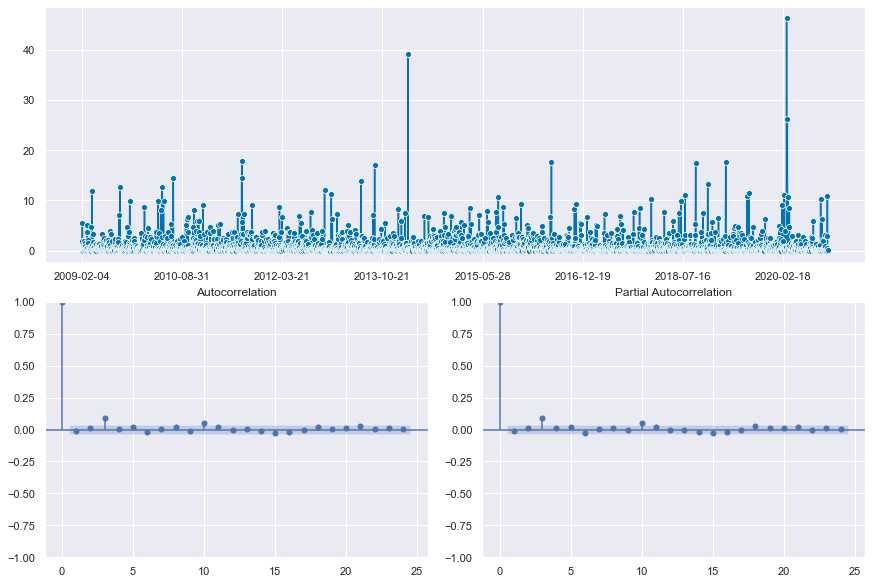

In [70]:
# Plot Autocorrelation

plot_correlations(mod1_std_resid**2)
ax.title =""
#el 3 es el q sale: 3 es significativo

#### c. Ljung-Box

Aquí observamos que L-Jung box, tiene con 3 retardos menor que 5%, por lo tanto, el modelo es correcto. Esté es una prueba estadística que comprueba si hay autocorrelación en un período de tiempo. La hipótesis nula en esta técnica es comprobar si los residuos se distribuyen de forma independiente, por lo tanto con retardos uno y dos no rechazamos la hipótesis nula.

In [71]:

print('Testing Ljung-Box')
test_Ljung_Box(mod1_std_resid**2, lags=[1,2,3], return_df=True)


Testing Ljung-Box


,lb_stat,lb_pvalue
1,0.586777,0.443668
2,1.119358,0.571393
3,25.185351,0.000014


In [72]:
from scipy.stats import t
from scipy import stats

Este tercer gráfico es un qqplot (cuantil- cuantil) este nos permite ver cuanto de cerca esta la distribución que hemos calculado con la distribución de un modelo ideal. En nuestro caso, nuestro modelo es muy similar al ideal, por tanto, nos encontramos que el modelo GARCH es un modelo bueno. 

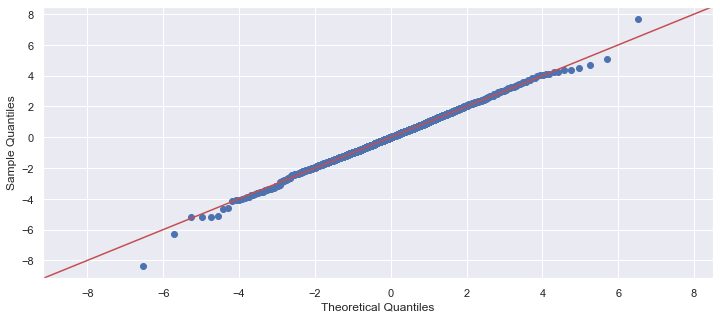

In [73]:
# qqplot t-student
sm.qqplot(mod1_std_resid,dist=stats.t,fit=True,line='45')
plt.show()

### Predecir la VOLATILIDAD (con Modelo GARCH)

####  ¿Cuál es la predicción para el mes de noviembre de 2020? ¿Son buenas predicciones? 

In [74]:
forecasts = res.forecast(horizon=21, reindex=False)
forecasts

In [75]:
mean_t=forecasts.mean.T
mean=pd.DataFrame(mean_t)
mean

Date,2020-10-30
h.01,0.068693
h.02,0.033049
h.03,0.030650
h.04,0.030488
h.05,0.030477
h.06,0.030477
h.07,0.030477
h.08,0.030477
h.09,0.030477
h.10,0.030477


<AxesSubplot:>

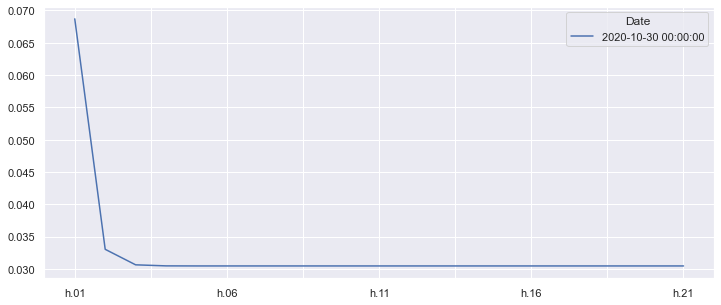

In [76]:
forecasts.mean.T.plot()

In [77]:
# Varianza
print("Esta es la varianza predecida")
varianza=(forecasts.variance**0.5)*np.sqrt(252)
varianza=varianza.T
vari=pd.DataFrame(varianza)
vari

Esta es la varianza predecida


Date,2020-10-30
h.01,30.579272
h.02,30.645423
h.03,30.642693
h.04,30.639666
h.05,30.636652
h.06,30.633652
h.07,30.630667
h.08,30.627696
h.09,30.624739
h.10,30.621796


<AxesSubplot:>

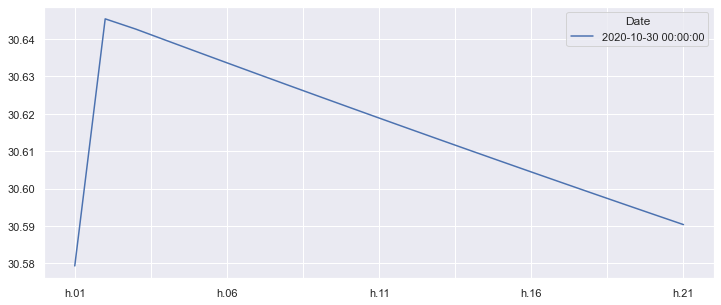

In [78]:
varianza.plot()

xx=pd.concat([mean, vari], axis=1)
xx

In [79]:
bmw_ot=bmw_o['2020-10-31':'2020-11-30']

In [80]:
print('Esta es la varianza normal')

vardf=bmw_ot["Adj Close"]
vardf_=vardf.var
vardf_

Esta es la varianza normal


<bound method NDFrame._add_numeric_operations.<locals>.var of Date
2020-11-02    52.965759
2020-11-03    55.131245
2020-11-04    55.486248
2020-11-05    57.500858
2020-11-06    56.426991
2020-11-09    60.021343
2020-11-10    61.680969
2020-11-11    62.426456
2020-11-12    62.745956
2020-11-13    62.781460
2020-11-16    64.600822
2020-11-17    64.654068
2020-11-18    65.559326
2020-11-19    65.674690
2020-11-20    65.807823
2020-11-23    65.577072
2020-11-24    68.053192
2020-11-25    66.917191
2020-11-26    65.790070
2020-11-27    64.867073
2020-11-30    64.822701
Name: Adj Close, dtype: float64>

Para predecir el mes de noviembre, hay que predecir la media y la varianza. La media es 0.304 y la varianza es 30.56. 

No son buenas predicciones por que hay que tener en cuenta más variables a la hora de predecir, es importante saber tipos de intereses, tasas, cambio de políticas… por tanto, yo no diría que es un buen modelo para predecir ya que necesitamos más variables.

Como podemos observar, la varianza durante el periodo de noviembre es muy distinta a la varianza predecida, con lo cual, este modelo tampoco nos serviría. Como he dicho antes, hay mucha información que es necesaria y con ella, mejoraríamos el modelo.  

En la varianza predecida da numeros muy parecidos, no cambia del 30, en cambio en la normal empieza en 52 y termina en 64. Por lo tanto, no tienen nada que ver. 


### TRADING PERO SIN MODELO GARCH

#### Plantea un sistema de trading diario para BMW a partir del modelo GARCH para el mes de noviembre de 2020. ¿Es rentable?


Para hacer un sistema de trading diario para BMW necesitamos entender las medias móviles, es un indicador que nos muestra las tendencias de la variable de precio y nos muestran las medias del histórico. Estas filtran el ruido ya que la volatilidad de los precios suele ser grandes en los mercados. Un sistema de trading es un sistema de reglas que ayudan al que necesite comprar o vender, especificando que momento es el adecuado para cuando tiene que operar para asacar mayor rendimiento. Para hacer un buen sistema trading necesitamos saber más información, ya que solo con el precio ajustado, no obtenemos mucho. Necesitamos información como índices macroeconómicos. Es uno de los sistemas mas fáciles y fiables del mercado.

Hemos creado una columna nueva en nuestro data que contenga una condición y cuando se cumpla la condición es 1 y se recomienda comprar, cuando no se cumpla es 0 se recomienda vender y cuando esta fuera del mercado es 0. 

En este ejercicio había que decir cuando la vendes, en este caso la compraría si el precio es mayor que 40, si es menor que 4 la vendería. El market es la diferencia de un día a otro del dataset principal, y strategy, es como el market ha ido comparando con el día anterior, pero lo multiplicaba por1, 0 o -1, por lo tanto, sabíamos cuando tendría que vender o cuando comprar. El problema de esta gráfica es que no es con los resultados de GARCH, pero se haría similar a como lo he hecho. 


In [81]:
ult=bmw_o['2009-01-31':'2020-11-30']
ult=ult[['Adj Close']]
ult

,Adj Close
Date,
2009-02-02,10.465375
2009-02-03,10.771431
2009-02-04,11.511320
2009-02-05,11.645033
2009-02-06,12.994060
...,...
2020-11-24,68.053192
2020-11-25,66.917191
2020-11-26,65.790070


In [82]:
from numpy import where

In [83]:
#bmw_TD=bmw_garch_1['2009-01-31':'2020-11-30']
daily_close=ult['2020-10-31':'2020-11-30']
daily_close

,Adj Close
Date,
2020-11-02,52.965759
2020-11-03,55.131245
2020-11-04,55.486248
2020-11-05,57.500858
2020-11-06,56.426991
2020-11-09,60.021343
2020-11-10,61.680969
2020-11-11,62.426456
2020-11-12,62.745956


In [84]:
daily_close['21ma']=daily_close['Adj Close'].rolling(window=21, min_periods=0).mean()
daily_close

C:\Users\CristinaRubiales\AppData\Local\Temp\ipykernel_21112\1327434774.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_close['21ma']=daily_close['Adj Close'].rolling(window=21, min_periods=0).mean()


,Adj Close,21ma
Date,,
2020-11-02,52.965759,52.965759
2020-11-03,55.131245,54.048502
2020-11-04,55.486248,54.527751
2020-11-05,57.500858,55.271028
2020-11-06,56.426991,55.502220
2020-11-09,60.021343,56.255407
2020-11-10,61.680969,57.030488
2020-11-11,62.426456,57.704984
2020-11-12,62.745956,58.265092


C:\Users\CristinaRubiales\AppData\Local\Temp\ipykernel_21112\2847131908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_close['21ma']=daily_close['Adj Close'].rolling(window=21, min_periods=0).mean()
C:\Users\CristinaRubiales\AppData\Local\Temp\ipykernel_21112\2847131908.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_close['REG']=where(daily_close['21ma']>40,1,0)
C:\Users\CristinaRubiales\AppData\Local\Temp\ipykernel_21112\2847131908.py:8: SettingWithCopyWarning: 
A value is trying to b

<AxesSubplot:xlabel='Date'>

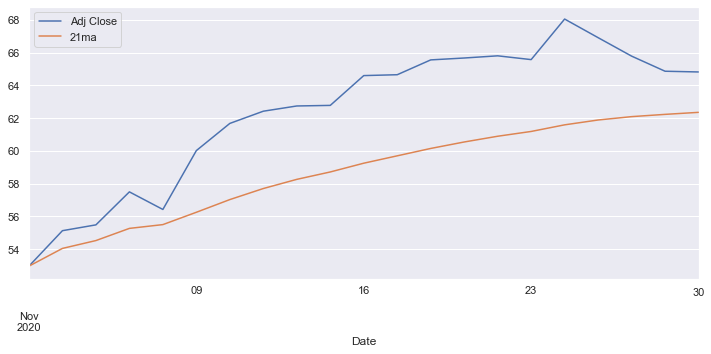

In [85]:
daily_close['21ma']=daily_close['Adj Close'].rolling(window=21, min_periods=0).mean()
#daily_close['210ma']=daily_close['Adj Close'].rolling(window=210, min_periods=1).mean()


#daily_close['dif']=daily_close['21ma']-daily_close['210ma']

daily_close['REG']=where(daily_close['21ma']>40,1,0)
daily_close['REG']=where(daily_close['21ma']<40,-1,daily_close['REG'])

daily_close[['Adj Close','21ma']].plot(grid=True)



C:\Users\CristinaRubiales\AppData\Local\Temp\ipykernel_21112\557178266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_close['MARKET']=daily_close['Adj Close']/daily_close['Adj Close'].shift(1)
C:\Users\CristinaRubiales\AppData\Local\Temp\ipykernel_21112\557178266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_close['STRATEGY']=daily_close['REG']*daily_close['MARKET'].shift(1)


<AxesSubplot:xlabel='Date'>

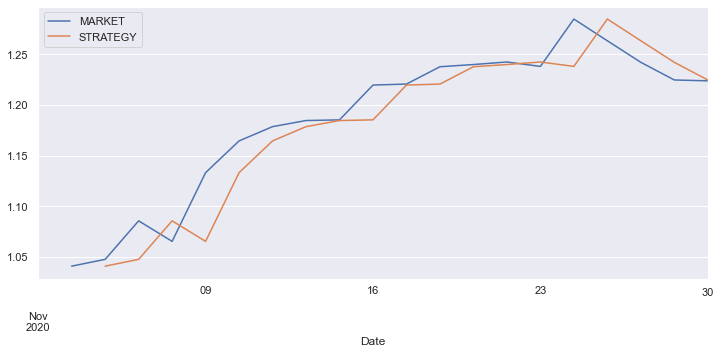

In [86]:
daily_close['MARKET']=daily_close['Adj Close']/daily_close['Adj Close'].shift(1)
daily_close['STRATEGY']=daily_close['REG']*daily_close['MARKET'].shift(1)
daily_close[['MARKET','STRATEGY']].cumprod().plot(grid=True)
#sigueb juntas hasta 21 muestras

video youtube

In [87]:
daily_close.tail(30)

,Adj Close,21ma,REG,MARKET,STRATEGY
Date,,,,,
2020-11-02,52.965759,52.965759,1,NaN,NaN
2020-11-03,55.131245,54.048502,1,1.040885,NaN
2020-11-04,55.486248,54.527751,1,1.006439,1.040885
2020-11-05,57.500858,55.271028,1,1.036308,1.006439
2020-11-06,56.426991,55.502220,1,0.981324,1.036308
2020-11-09,60.021343,56.255407,1,1.063699,0.981324
2020-11-10,61.680969,57.030488,1,1.027651,1.063699
2020-11-11,62.426456,57.704984,1,1.012086,1.027651
2020-11-12,62.745956,58.265092,1,1.005118,1.012086


### Conclusión

Los dos modelos que hemos creado no son muy buenos predictores, ya que no nos muestran datos similares a los que hansido realmente. Estos datos deberían dar más información, nose puede predecir bien con tan poca información. He ido paso a paso explicando como he ejecutado todo y como el modelo VAr y el modelo GArch no nos isrven para predecir estos datos de BMW y Volskwgen